In [1]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from scipy.integrate import newton_cotes

%config InlineBackend.figure_format='retina'

# Problem 1

In [ ]:
def get_slopes(x, v, spline_type, alpha=0, beta=0):
    dx = x[1:] - x[:-1] # x_{i+1} - x_{i}, i = 1,...,N-1
    dv = v[1:] - v[:-1] # v_{i+1} - v_{i}, i = 1,...,N-1
    D = np.zeros((v.shape[0]-2, v.shape[0]))
    ind = np.arange(v.shape[0]-2)
    D[ind, ind] = dx[1:]
    D[ind, ind+2] = dx[:-1]
    D[ind, ind+1] = 2*(dx[1:] + dx[:-1])
    b = 3*(dv[:-1] * dx[1:] / dx[:-1] + dv[1:] * dx[:-1] / dx[1:])

    if spline_type == "natural":
        row_1 = np.array([2, 1] + [0,]*(D.shape[1]-2)).reshape(1, -1)
        row_N = np.array([0,]*(D.shape[1]-2) + [1, 2]).reshape(1, -1)
        b_1 = np.array([3 * dv[0] / dx[0],])
        b_2 = np.array([3 * dv[-1] / dx[-1],])

    elif spline_type == "clamped":
        row_1 = np.array([1, 0] + [0,]*(D.shape[1]-2)).reshape(1, -1)
        row_N = np.array([0,]*(D.shape[1]-2) + [0, 1]).reshape(1, -1)
        b_1 = np.array([alpha,])
        b_2 = np.array([beta,])

    D = np.concatenate([row_1, D, row_N], 0)
    b = np.concatenate([b_1, b, b_2])

    s = np.linalg.solve(D, b)
    return s

def evaluate_spline(x_, x, v, s):
    if x_ == x[-1]:
      x0, v0, s0 = x[x < x_][-1], v[x < x_][-1], s[x < x_][-1]
      x1, v1, s1 = x[x >= x_][0], v[x >= x_][0], s[x >= x_][0]
    else:
      x0, v0, s0 = x[x <= x_][-1], v[x <= x_][-1], s[x <= x_][-1]
      x1, v1, s1 = x[x > x_][0], v[x > x_][0], s[x > x_][0]
    dv_dx = (v1 - v0) / (x1 - x0)
    res = v0 + dv_dx * (x_ - x0) + (dv_dx - s0) * (x_ - x0) * (x_ - x1) / (x1 - x0) + (s1 + s0 - 2*dv_dx) * (x_ - x0)**2 * (x_ - x1) / (x1 - x0)**2
    return res

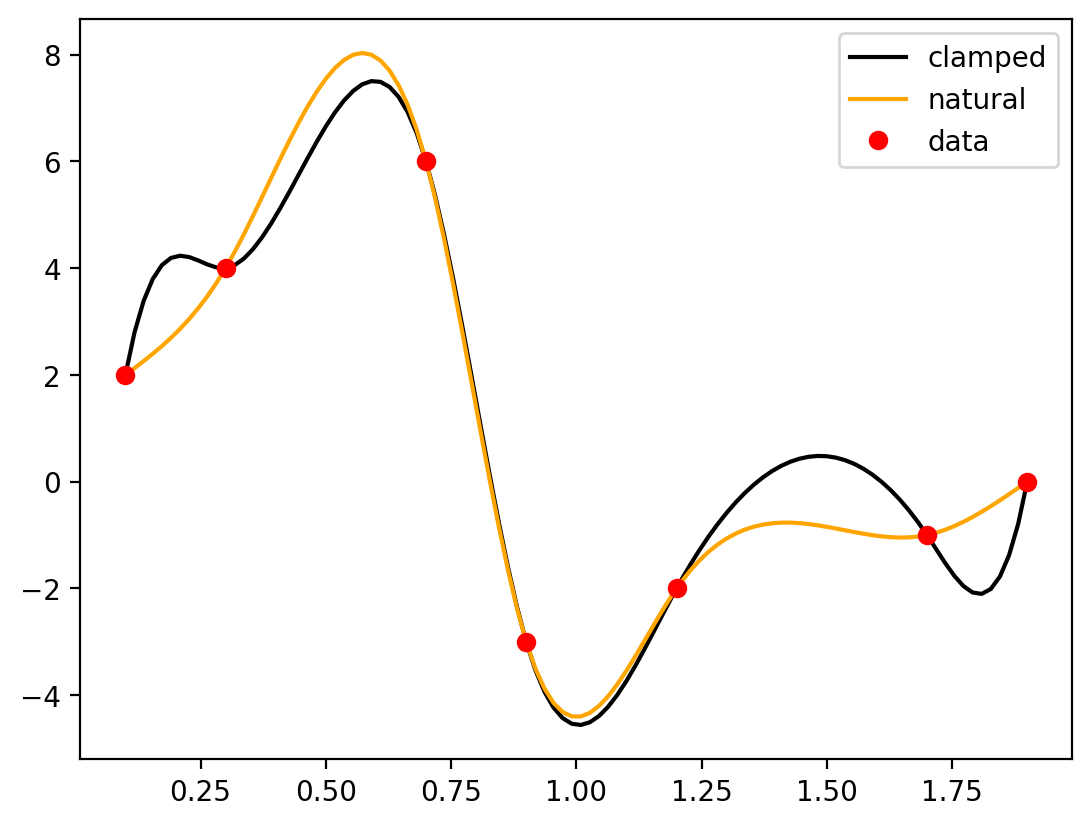

In [ ]:
# sanity check

# function
x = np.array([0.1, 0.3, 0.7, 0.9, 1.2, 1.7, 1.9])
v = np.array([2, 4, 6, -3, -2, -1, 0])

# interpolation grid
N_eval = 100
x_eval = np.linspace(x[0], x[-1], N_eval)

# use large derivatives for clamped spline, should observe wiggly curve near the ends
alpha = +50
beta = +50

# interpolate with clamped spline
s = get_slopes(x, v, "clamped", alpha=alpha, beta=beta)
interpolated = []
for x_ in x_eval:
    interpolated.append(evaluate_spline(x_, x, v, s))
interpolated = np.array(interpolated)
plt.plot(x_eval, interpolated, color="black", label="clamped")

# interpolate with natural spline
s = get_slopes(x, v, "natural")
interpolated = []
for x_ in x_eval:
    interpolated.append(evaluate_spline(x_, x, v, s))
interpolated = np.array(interpolated)

plt.plot(x_eval, interpolated, color="orange", label="natural")
plt.plot(x, v, "o", color="red", label="data")
plt.legend();

# Problem 2

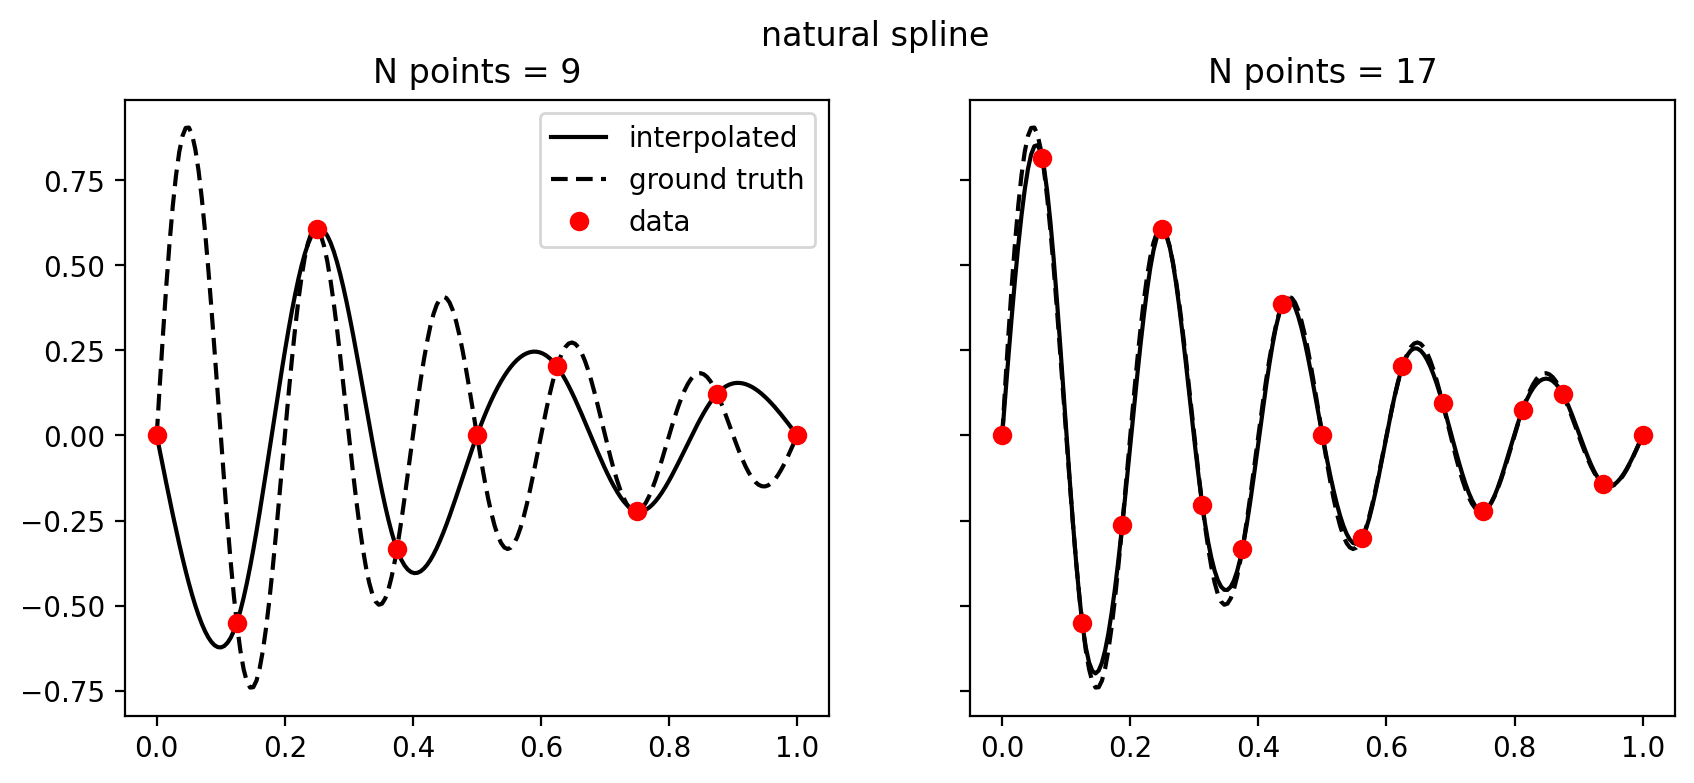

In [ ]:
N_eval = 200

x_eval = np.linspace(0, 1.0, N_eval)
v_eval = np.exp(-2*x_eval)*np.sin(10*np.pi*x_eval)

fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

Ns = [9, 17]
for i, N in enumerate(Ns):
    x = np.linspace(0, 1, N)
    v = np.exp(-2*x)*np.sin(10*np.pi*x)

    s = get_slopes(x, v, "natural")
    interpolated = []
    for x_ in x_eval:
        interpolated.append(evaluate_spline(x_, x, v, s))
    interpolated = np.array(interpolated)

    ax[i].plot(x_eval, interpolated, color="black", label="interpolated")
    ax[i].plot(x_eval, v_eval, dashes=[4, 2, 4, 2], color="black", label="ground truth")
    ax[i].plot(x, v, "o", color="red", label="data")
    ax[i].set_title(f"N points = {N}")
ax[0].legend()
plt.suptitle("natural spline");

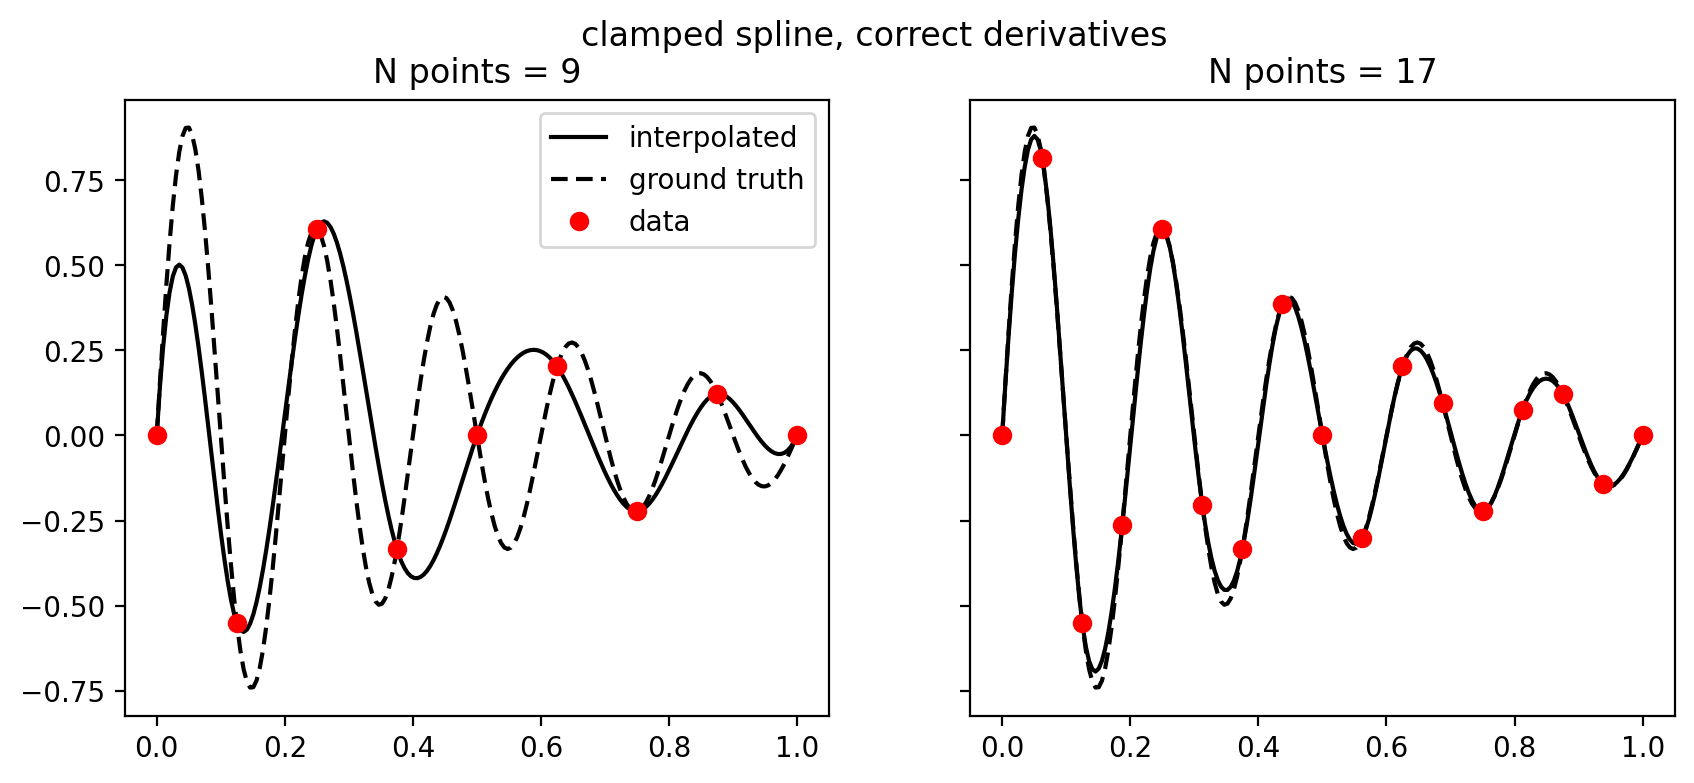

In [ ]:
N_eval = 200

x_eval = np.linspace(0, 1.0, N_eval)
v_eval = np.exp(-2*x_eval)*np.sin(10*np.pi*x_eval)
# df/dx = -2*f + 10*pi*exp(-2*x)*cos(10*pi*x)
df_dx = lambda x: -2*np.exp(-2*x)*np.sin(10*np.pi*x) + 10*np.pi*np.exp(-2*x)*np.cos(10*np.pi*x)
alpha = df_dx(0)
beta = df_dx(1)

fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

Ns = [9, 17]
for i, N in enumerate(Ns):
    x = np.linspace(0, 1, N)
    v = np.exp(-2*x)*np.sin(10*np.pi*x)

    s = get_slopes(x, v, "clamped", alpha=alpha, beta=beta)
    interpolated = []
    for x_ in x_eval:
        interpolated.append(evaluate_spline(x_, x, v, s))
    interpolated = np.array(interpolated)

    ax[i].plot(x_eval, interpolated, color="black", label="interpolated")
    ax[i].plot(x_eval, v_eval, dashes=[4, 2, 4, 2], color="black", label="ground truth")
    ax[i].plot(x, v, "o", color="red", label="data")
    ax[i].set_title(f"N points = {N}")
ax[0].legend()
plt.suptitle("clamped spline, correct derivatives");

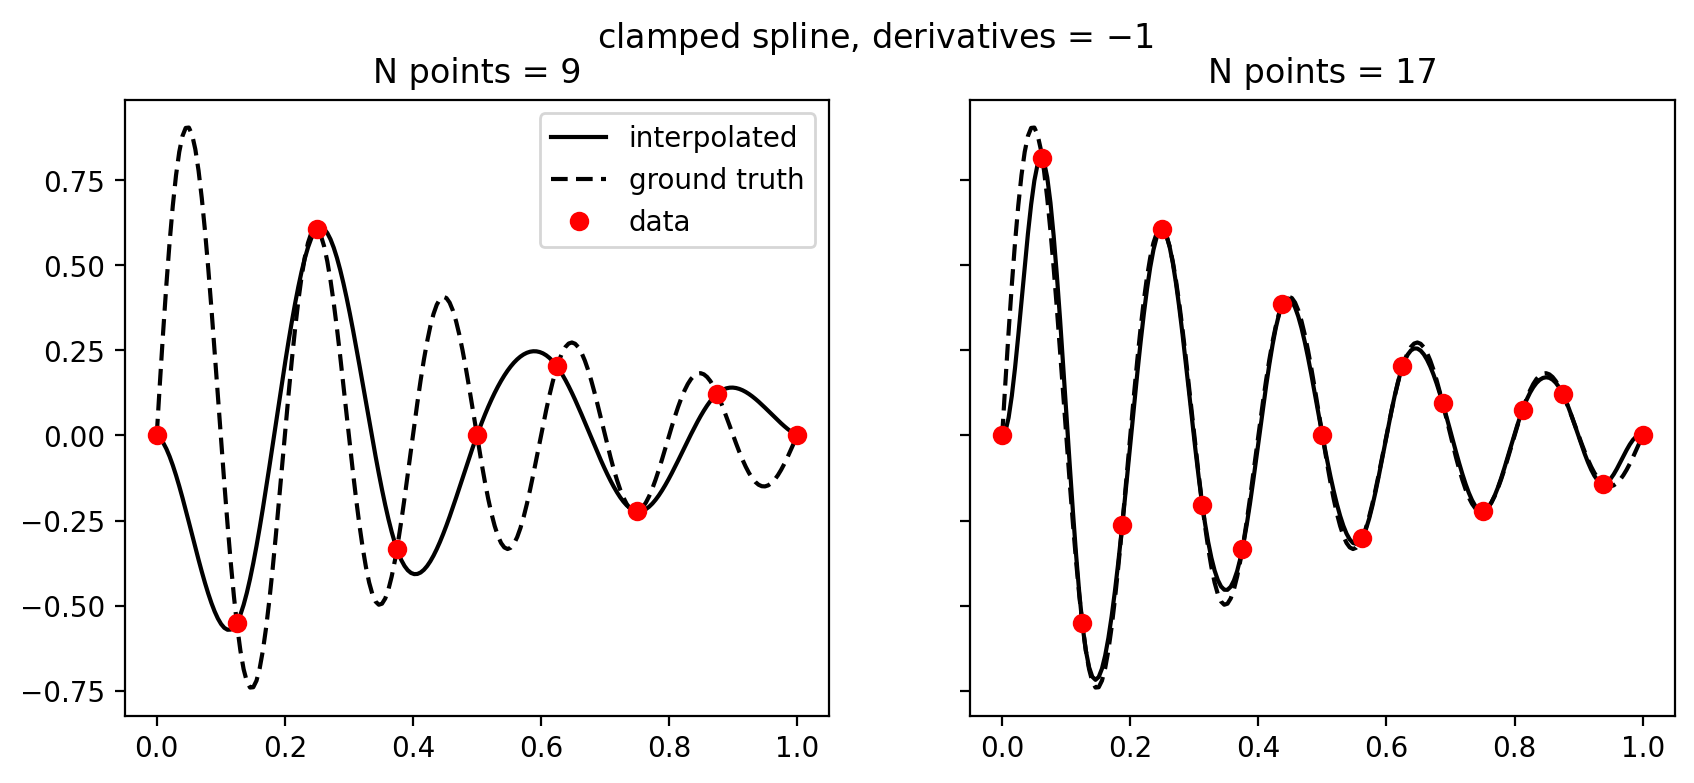

In [ ]:
N_eval = 200

x_eval = np.linspace(0, 1.0, N_eval)
v_eval = np.exp(-2*x_eval)*np.sin(10*np.pi*x_eval)
# df/dx = -2*f + 10*pi*exp(-2*x)*cos(10*pi*x)
df_dx = lambda x: -2*np.exp(-2*x)*np.sin(10*np.pi*x) + 10*np.pi*np.exp(-2*x)*np.cos(10*np.pi*x)
alpha = -1.0
beta = -1.0

fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

Ns = [9, 17]
for i, N in enumerate(Ns):
    x = np.linspace(0, 1, N)
    v = np.exp(-2*x)*np.sin(10*np.pi*x)

    s = get_slopes(x, v, "clamped", alpha=alpha, beta=beta)
    interpolated = []
    for x_ in x_eval:
        interpolated.append(evaluate_spline(x_, x, v, s))
    interpolated = np.array(interpolated)

    ax[i].plot(x_eval, interpolated, color="black", label="interpolated")
    ax[i].plot(x_eval, v_eval, dashes=[4, 2, 4, 2], color="black", label="ground truth")
    ax[i].plot(x, v, "o", color="red", label="data")
    ax[i].set_title(f"N points = {N}")
ax[0].legend()
plt.suptitle("clamped spline, derivatives = $-1$");

# Problem 3

Hermit's spline are defined by three conditions:

1. Piecewise polynomial passes exactly through points $\left\{x_i, v_i\right\}$.
2. Polynomial is continuously differentiable.
3. Boundary conditions if boundary is present.


To derive conditions for cubic splines we will start with a supplementary problem.

**Supplementary problem.**

Find coefficients of $f(x) = c_0 + c_1 x + c_2 x^2 + c_3 x^3$ such that
\begin{equation}
  \begin{split}
    f(x_i) &= v_i,\\
    f(x_{i+1}) &= v_{i+1},\\
    f^{'}(x_i) &= s_i,\\
    f^{'}(x_{i+1}) &= s_{i+1}.\\
  \end{split}
\end{equation}

In words: we want polynomial to pass through prescribed points and to have a prescribed slope at those points.

If we are to find such representation we can automatically fulfill first condition above and one smoothness condition (that derivatives are the same). After that we will left with condition for second derivative and special conditions on the boundary.

**Construction for supplementary problem.**

In principle we have four linear equations that we can solve directly. This is rather tedious, so we will simplify problem by construction polynomials that pass through $(x_i, v_i)$ and $(x_{i+1}, v_{i+1})$.

Since $f(x)$ is a polynomial, condition $f(x_i) = v_i$ implies that
$$
f(x_i) - v_i = p(x_i) = 0,
$$
where $p(x)$ is a polynomial of degree $3$ that has root at $x_i$. In other words
$$
f(x) = v_i + q(x)(x - x_i),
$$
where $q(x)$ is arbitrary polynomial of degree $2$.

Now, the second condition $f(x_{i+1}) = v_{i+1}$ gives us
$$
f(x_{i+1}) - v_{i+1} = v_{i} + q(x_{i+1})(x_{i+1} - x_i) - v_{i+1} = 0 \Leftrightarrow q(x_{i+1}) = \frac{v_{i+1} - v_i}{x_{i+1} - x_{i}}.
$$
We see that $q(x) - \frac{v_{i+1} - v_i}{x_{i+1} - x_{i}}$ is a polynomial of degree $2$ that has root at $x_{i+1}$. So, we can write
$$
q(x) = \frac{v_{i+1} - v_i}{x_{i+1} - x_{i}} + (x - x_{i+1})(ax + b),
$$
where $a$ and $b$ are arbitrary coefficients.

So far we were able to fond general parametrisation for polynomial that passes through $(x_i, v_i)$ and $(x_{i+1}, v_{i+1})$:
$$
f(x) = v_i + (x - x_i)\left(\frac{v_{i+1} - v_{i}}{x_{i+1} - x_{i}} + (x - x_{i+1})(ax + b)\right).
$$
To find $a$ and $b$ we will solve linear system that follows from to remaining conditions. To simplify notation we will use $\Delta = x_{i+1} - x_{i}$ and $\alpha = \frac{v_{i+1} - v_{i}}{x_{i+1} - x_{i}}$.

Special structure of the expression above allows us easily write down derivatives evaluated at $x_i$ and $x_{i+1}$:
\begin{equation}
  \begin{split}
    \alpha - \Delta (ax_i + b) &= s_i,\\
    \alpha + \Delta (a x_{i+1} + b) &= s_{i+1}.\\
  \end{split}
\end{equation}
The system has simple form, so it is straighforward to eliminate each variable. To eliminate $b$ we need to add two equations:
$$
2 \alpha + \Delta^2 a x_i = s_i + s_{i+1} \Rightarrow a = \frac{1}{\Delta^2}\left(s_i + s_{i+1} - 2\alpha\right).
$$
To eliminate $a$ we need to multiply first equation by $x_{i+1}$, second eqution by $x_i$ and add them:
$$
\alpha(x_{i+1} + x_{i}) -\Delta^2 b = s_{i}x_{i+1} + s_{i+1} x_{i} \Rightarrow b = \frac{1}{\Delta^2}\left(\alpha(x_{i+1} + x_{i}) - \left(s_{i}x_{i+1} + s_{i+1} x_{i}\right)\right).
$$

Our final answer to supplementary problem reads:
$$
f(x) = v_i + (x - x_i)\left(\frac{v_{i+1} - v_{i}}{x_{i+1} - x_{i}} + \frac{(x - x_{i+1})}{\Delta^2}\left(\left(s_i + s_{i+1} - 2\alpha\right)x + \left(\alpha(x_{i+1} + x_{i}) - \left(s_{i}x_{i+1} + s_{i+1} x_{i}\right)\right)\right)\right).
$$

To allign this expression with the same form as in the assignment we transform expression in brackets
$$
\left(s_i + s_{i+1} - 2\alpha\right)x + \left(\alpha(x_{i+1} + x_{i}) - \left(s_{i}x_{i+1} + s_{i+1} x_{i}\right)\right) = \left(s_i + s_{i+1} - 2\alpha\right)(x - x_{i} + x_{i}) + \left(\alpha(x_{i+1} + x_{i}) - \left(s_{i}x_{i+1} + s_{i+1} x_{i}\right)\right) = \left(s_i + s_{i+1} - 2\alpha\right)(x - x_{i}) + s_i x_i + s_{i+1} x_{i} - 2\alpha x_i + \alpha x_{i+1} + \alpha x_{i} - s_i x_{i+1} - s_{i+1} x_i = \left(s_i + s_{i+1} - 2\alpha\right)(x - x_{i}) + \left(\alpha - s_{i}\right) \Delta.
$$

Our final expression is

$$
f(x) = v_i + (x - x_i)\alpha + (x - x_i)(x - x_{i+1}) \frac{\alpha - s_i}{\Delta} + (x - x_i)^2(x - x_{i+1})\frac{s_i + s_{i+1} - 2\alpha}{\Delta^2},
$$
where
\begin{equation}
  \alpha = \frac{v_{i+1} - v_{i}}{x_{i+1} - x_{i}},\,\Delta = x_{i+1} - x_{i}.
\end{equation}

With that we reproduced Equation (2) from Problem 1.

**Construction for Hermit's spline.**

Using previous result we can find equation for Hermit's spline.

1. Snce we already have piecewise polynomial that passes through points $(x_i, v_i)$ first condition for spline is valid.

2. We also know that our polynomial has slopes $s_i$ and $s_{i+1}$ at $x_i$ and $x_{i+1}$, and because of that conditions for smoothness becomes trivial. More specifically, we simply ask that $s_{i+1}$ on the interval $[x_{i}, x_{i+1}]$ is the same as the slope on the left end of the interval $[x_{i+1}, x_{i}]$.

3. The values $v_i$ are known, but slopes $s_{i}$ are unknown. To fixe them we ask piecewise polynomial to be continuously differentiably. First we need to find second derivative on the interval $[x_i, x_{i+1}]$:
$$
f^{''}(x) = 2\frac{\frac{v_{i+1} - v_{i}}{x_{i+1} - x_{i}} - s_i}{x_{i+1} - x_{i}} + 2(3x - 2x_{i} - x_{i+1}) \frac{s_i + s_{i+1} - 2\frac{v_{i+1} - v_{i}}{x_{i+1} - x_{i}}}{(x_{i+1} - x_{i})^2}.
$$
Next, we evaluate this expression in $x_{i+1}$ and obtain
$$
2\frac{\frac{v_{i+1} - v_{i}}{x_{i+1} - x_{i}} - s_i}{x_{i+1} - x_{i}} + 4 \frac{s_i + s_{i+1} - 2\frac{v_{i+1} - v_{i}}{x_{i+1} - x_{i}}}{x_{i+1} - x_{i}} = \frac{2}{x_{i+1} - x_{i}}\left(s_i + 2 s_{i+1} - 3\frac{v_{i+1} - v_{i}}{x_{i+1} - x_{i}}\right).
$$
We need to equate this with derivative on the left end of $[x_{i+1}, x_{i+2}]$. To find derivative on this interval we use expression above with indices shifted to $+1$
$$
f^{''}(x) = 2\frac{\frac{v_{i+2} - v_{i+1}}{x_{i+2} - x_{i+1}} - s_{i+1}}{x_{i+2} - x_{i+1}} + 2(3x - 2x_{i+1} - x_{i+2}) \frac{s_{i+1} + s_{i+2} - 2\frac{v_{i+2} - v_{i+1}}{x_{i+2} - x_{i+1}}}{(x_{i+2} - x_{i+1})^2}.
$$
We evaluate this expression at $x_{i+1}$ and obtain
$$
2\frac{\frac{v_{i+2} - v_{i+1}}{x_{i+2} - x_{i+1}} - s_{i+1}}{x_{i+2} - x_{i+1}} - 2\frac{s_{i+1} + s_{i+2} - 2\frac{v_{i+2} - v_{i+1}}{x_{i+2} - x_{i+1}}}{x_{i+2} - x_{i+1}} = \frac{2}{x_{i+2} - x_{i+1}}\left(-s_{i+2} - 2s_{i+1} + 3 \frac{v_{i+2} - v_{i+1}}{x_{i+2} - x_{i+1}}\right).
$$

Finnaly we equate these two expressions
$$
\frac{2}{x_{i+1} - x_{i}}\left(s_i + 2 s_{i+1} - 3\frac{v_{i+1} - v_{i}}{x_{i+1} - x_{i}}\right) = \frac{2}{x_{i+2} - x_{i+1}}\left(-s_{i+2} - 2s_{i+1} + 3 \frac{v_{i+2} - v_{i+1}}{x_{i+2} - x_{i+1}}\right)
$$

and obtain after minor simplifications
$$
s_i(x_{i+2} - x_{i+1}) + 2s_{i+1}(x_{i+2} - x_{i}) + s_{i+2}(x_{i+1} - x_{i}) = 3\left((v_{i+1} - v_{i})\frac{x_{i+2} - x_{i+1}}{x_{i+1} - x_{i}} + (v_{i+2} - v_{i+1})\frac{x_{i+1} - x_{i}}{x_{i+2} - x_{i+1}}\right).
$$

This is precisely the expression from Problem 1.

The condition above is suitable for inner points $i = 1,\dots, N-2$. The form of conditions for boundary point depend on the type of the spline. Two cases that we are intrested in are covered below.

**Natural cubic spline.**

Conditions are $f^{''}(x_{1}) = f^{''}(x_{N}) = 0$.

On the left boundary
$$
2 \frac{\frac{v_2 - v_1}{x_2 - x_1} - s_1}{x_2 - x_1} - 2 \frac{s_1 + s_2 - 2\frac{v_2 - v_1}{x_2 - x_1}}{x_2 - x_1} = 0 \Rightarrow  2 s_1 + s_2 = 3 \frac{v_2 - v_1}{x_2 - x_1}
$$

On the right boundary
$$
2 \frac{\frac{v_N - v_{N-1}}{x_{N} - x_{N-1}} - s_{N-1}}{x_{N} - x_{N-1}} + 4 \frac{s_{N-1} + s_{N} - 2\frac{v_N - v_{N-1}}{x_{N} - x_{N-1}}}{x_{N} - x_{N-1}} = 0 \Rightarrow  2 s_{N} + s_{N-1} = 3 \frac{v_N - v_{N-1}}{x_{N} - x_{N-1}}
$$

**Clamped spline.**

In this case we prescribe slopes at the endpoints
$$
s_{1} = \alpha,\,s_{N} = \beta.
$$


# Problem 4

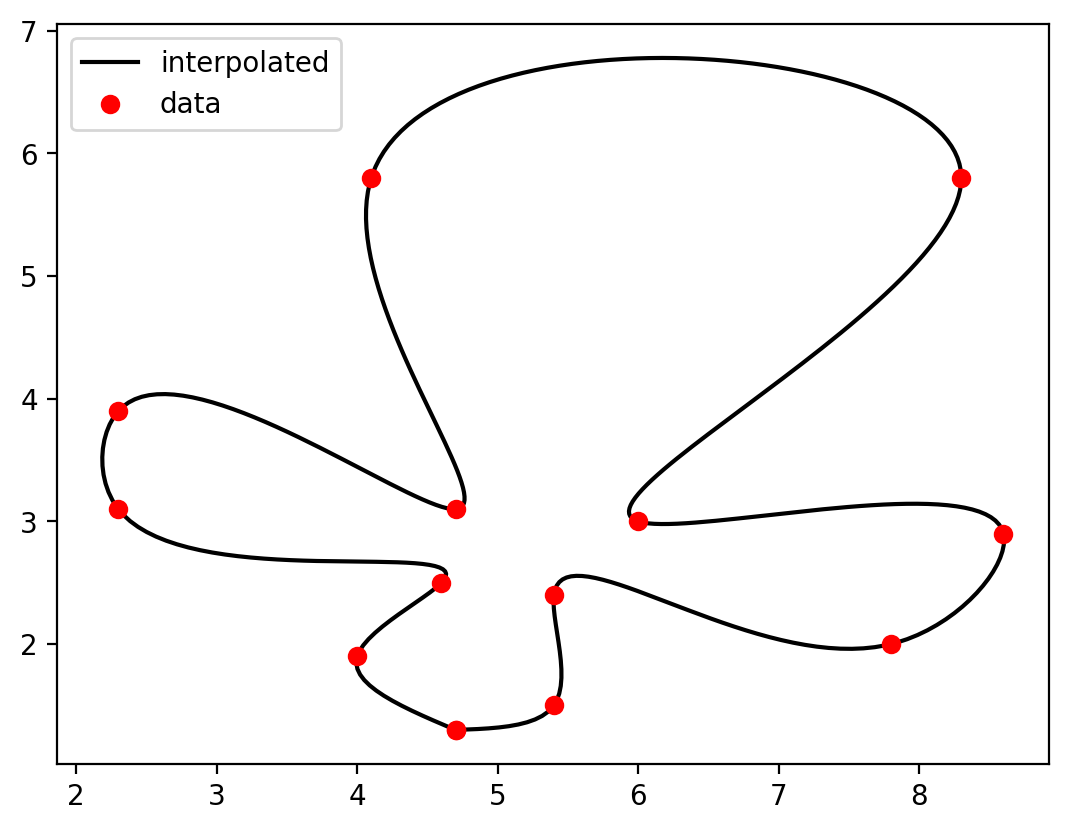

In [ ]:
N_eval = 400

x = np.array([4.7, 4.0, 4.6, 2.3, 2.3, 4.7, 4.1, 8.3, 6.0, 8.6, 7.8, 5.4, 5.4, 4.7])
y = np.array([1.3, 1.9, 2.5, 3.1, 3.9, 3.1, 5.8, 5.8, 3.0, 2.9, 2.0, 2.4, 1.5, 1.3])

dx = x[1:] - x[:-1]
dy = y[1:] - y[:-1]
ds = np.sqrt(dx**2 + dy**2)
ds = np.concatenate([np.zeros((1,)), ds])
s = np.cumsum(ds)
x_eval = np.linspace(s[0], s[-1], N_eval)

s_ = get_slopes(s, x, "natural")
interpolated = []
for x_ in x_eval:
    interpolated.append(evaluate_spline(x_, s, x, s_))
interpolated_x_ = np.array(interpolated)

s_ = get_slopes(s, y, "natural")
interpolated = []
for x_ in x_eval:
    interpolated.append(evaluate_spline(x_, s, y, s_))
interpolated_y_ = np.array(interpolated)

plt.plot(interpolated_x_, interpolated_y_, color="black", label="interpolated")
plt.plot(x, y, "o", color="red", label="data")
plt.legend();

Since curve is closed, one may want to use periodic boundary conditions. To do so without rewriting the code we augment $(x_i, y_i)$ with one point on the left end and one point on the right end. After finding slopes we discard these additional points (and their arclength).

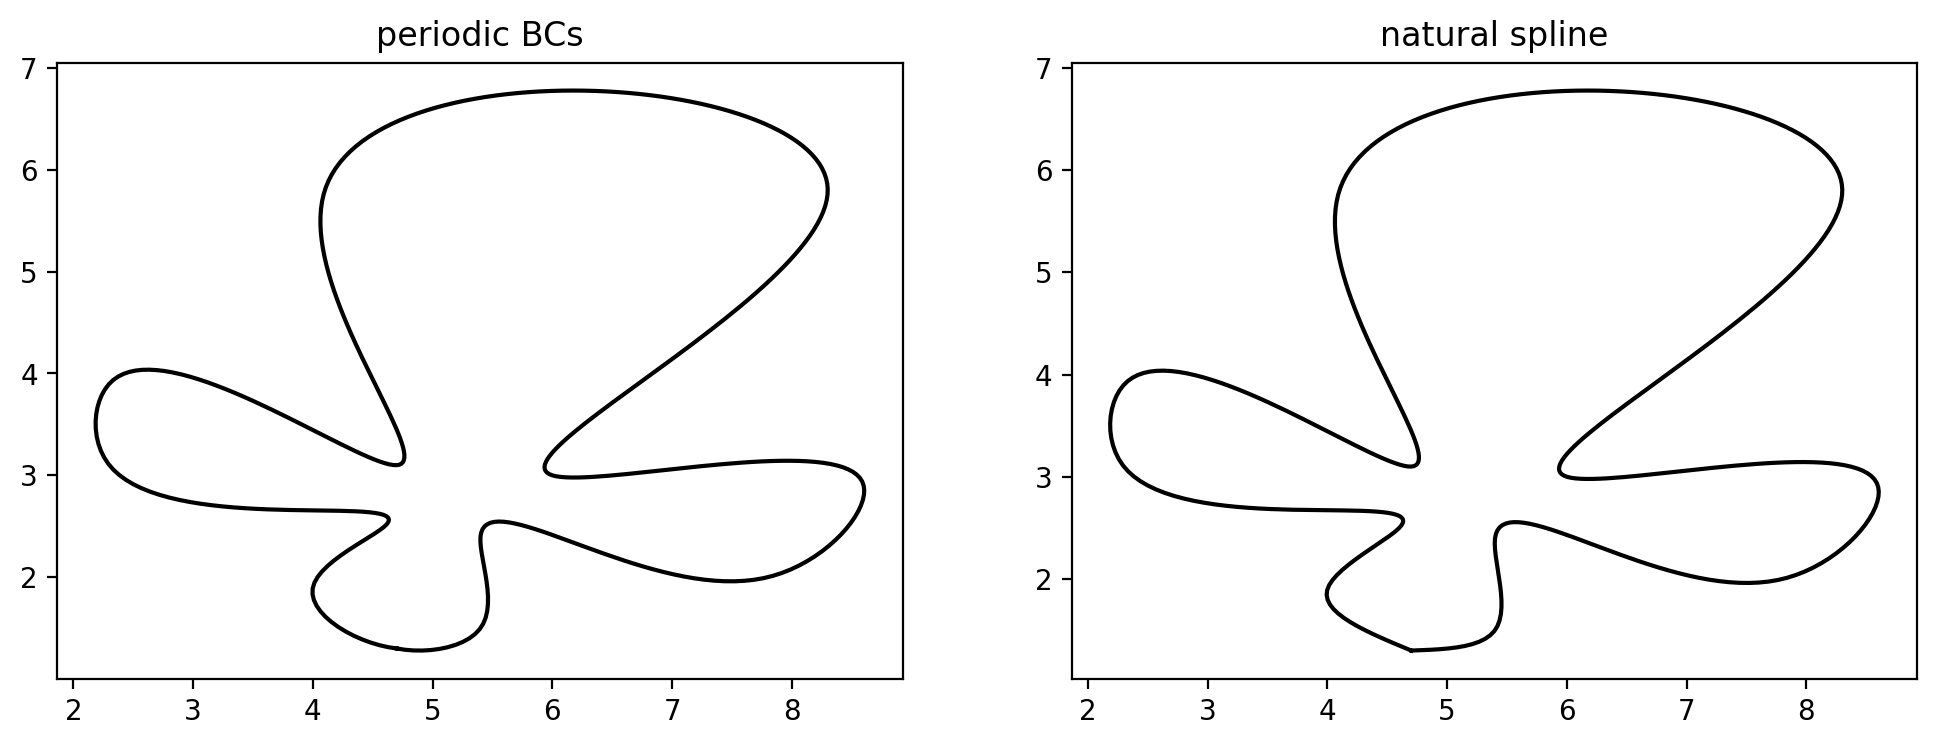

In [ ]:
N_eval = 400

x = np.array([5.4, 4.7, 4.0, 4.6, 2.3, 2.3, 4.7, 4.1, 8.3, 6.0, 8.6, 7.8, 5.4, 5.4, 4.7, 4.0,])
y = np.array([1.5, 1.3, 1.9, 2.5, 3.1, 3.9, 3.1, 5.8, 5.8, 3.0, 2.9, 2.0, 2.4, 1.5, 1.3, 1.9])

dx = x[1:] - x[:-1]
dy = y[1:] - y[:-1]
ds = np.sqrt(dx**2 + dy**2)
ds = np.concatenate([np.zeros((1,)), ds])
s = np.cumsum(ds)
x_eval = np.linspace(s[1], s[-2], N_eval)

s_ = get_slopes(s, x, "natural")[1:-1]
interpolated = []
for x_ in x_eval:
    interpolated.append(evaluate_spline(x_, s[1:-1], x[1:-1], s_))
interpolated_x = np.array(interpolated)

s_ = get_slopes(s, y, "natural")[1:-1]
interpolated = []
for x_ in x_eval:
    interpolated.append(evaluate_spline(x_, s[1:-1], y[1:-1], s_))
interpolated_y = np.array(interpolated)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(interpolated_x, interpolated_y, color="black", label="interpolated")
ax[0].set_title("periodic BCs")
ax[1].plot(interpolated_x_, interpolated_y_, color="black", label="interpolated")
ax[1].set_title("natural spline");

# Problem 5

In [ ]:
def get_Hilbert_matrix(n):
  ind = np.arange(1, n+1)
  H = 1 / (ind.reshape(1, -1) + ind.reshape(-1, 1) - 1)
  return H

In [ ]:
N = 10
H = get_Hilbert_matrix(N)

for n in [6, 8]:
    exact_solution = np.ones((n,))
    b = H[:, :n] @ exact_solution
    Q, R = np.linalg.qr(H[:, :n])
    approximate_solution_qr = np.linalg.solve(R, Q.T @ b)
    error = np.linalg.norm(approximate_solution_qr - exact_solution)
    print("n =", n)
    print("qr error", error)
    A = H[:, :n].T @ H[:, :n]
    approximate_solution_normal = np.linalg.solve(A, H[:, :n].T @ b)
    error = np.linalg.norm(approximate_solution_normal - exact_solution)
    print("error from normal equation", error, "\n")

n = 6
qr error 1.3824815869728285e-10
error from normal equation 0.0002804024610966714 

n = 8
qr error 4.0666232220769367e-07
error from normal equation 37.76542847547257 



The text below is taken from Problem 6, HW 2:

Consider equation $Ax = b$. If we perturb $b$ by $\delta b$ the error between exact solution and the one obtained from the perturbed right-hand side is $\left\|A^{-1} b - (A^{-1}b + A^{-1}\delta b)\right\| = \left\|A^{-1}\delta b\right\|$. So the relative error is
$$
\frac{\left\|A^{-1}\delta b\right\|}{\left\|A^{-1}b\right\|} = \frac{\left\|\delta b\right\|}{\left\|b\right\|}\frac{\left\|A^{-1}\delta b\right\|}{\left\|\delta b\right\|} \frac{\left\|b\right\|}{\left\|A^{-1}b\right\|} \leq \frac{\left\|\delta b\right\|}{\left\|b\right\|} \left(\sup_{\delta_b} \frac{\left\|A^{-1}\delta b\right\|}{\left\|\delta b\right\|}\right) \left(\sup_{b} \frac{\left\|b\right\|}{\left\|A^{-1}b\right\|}\right) = \frac{\left\|\delta b\right\|}{\left\|b\right\|} \left\|A^{-1}\right\| \left\|A\right\| = \frac{\left\|\delta b\right\|}{\left\|b\right\|} \text{cond}(A).
$$

This mean that relative error in the right-hand side of the system is *in the worst case* lead to $\text{cond}(A)$ larger relative error in the solution.

Now, in our case we have normal equation. If we consider condition number for $L_2$ operator norm, we have

\begin{equation}
  \begin{split}
    A &= U \Sigma V^{\top} \Rightarrow \text{cond}(A) = \frac{\max_{i} \Sigma_{ii}}{\min_{i} \Sigma_{ii}};\\
    A^{\top} A &= V \Sigma^2 V^\top \Rightarrow \text{cond}(A^{\top} A) = \left(\frac{\max_{i} \Sigma_{ii}}{\min_{i} \Sigma_{ii}}\right)^2 = \left(\text{cond}(A)\right)^2.
  \end{split}
\end{equation}

This exaplains why error is larger for normal equation than for QR. To get more insights lets compute condition number for both of these equations.

In [ ]:
N = 10
H = get_Hilbert_matrix(N)

for n in [6, 8]:
    exact_solution = np.ones((n,))
    sigmas = np.linalg.svdvals(H[:, :n])
    cond = sigmas[0] / sigmas[-1]
    print(f"n = {n}, coldition number = {cond}")

n = 6, coldition number = 2450593.200897123
n = 8, coldition number = 3565872484.719897


We see that for $n=6$ the condition number is roughly $10^{7}$, and for $n=8$ is roughly $10^{10}$. This mean we will lose $7$ and $10$ digits for QR and $14$ and $20$ digits for normal equation. This alighns well with what we observed above.

# Problem 8

I am going to use the following definition of closed Newton-Cotes rules.

Let $x_i = ih =  \frac{i}{N-1},\,i=0,\dots,N-1$ be a uniform grid with $N$ points. Let $l_i(x) = \prod_{k = 0,\dots, N-1 k\neq i}\frac{x - x_i}{x_k - x_i}$ be Lagrange basis functions. Closed Newton-Cotes rule is a sum that approximate integral
$$
\int_{0}^{1} dx\,f(x) \simeq \sum_{i=0}^{N-1} f(x_i) w_i,\text{ where }w_{i} = \int_{0}^{1}dx\,l_{i}(x).
$$

I will show that if $f(x)$ is a polynomial of degree $\leq N-1$ Newton-Cotes rule with $N$ points integrate it exactly.
$$
I_{\text{Newton-Cotes}} = \sum_{i=0}^{N-1} f(x_i) w_i = \sum_{i=0}^{N-1} f(x_i) \int_{0}^{1}dx\,l_{i}(x) = \int_{0}^{1}dx\,\left(\sum_{i=0}^{N-1}f(x_i)l_{i}(x)\right).
$$

If $f(x)$ is polynomial of degree $\leq N-1$, the difference between Lagrange polynomial $L(x) = \sum_{i=0}^{N-1}f(x_i)l_{i}(x)$ and $f(x)$ is polynomial of degree $\leq N-1$. Observe that by construction $\left.\left(f(x) - L(x)\right)\right|_{x=x_i} = 0$ for each $x_i$. Since we have $N$ distinct $x_i$, polynomial $f(x) - L(x)$ has degree $\leq N-1$ and $N$ distinct roots. This mean $f(x) - L(x) = 0$, since $0$ is the only polynomial with this property. Given that we conclude
$$
\int_{0}^{1}dx\,\left(\sum_{i=0}^{N-1}f(x_i)l_{i}(x)\right) = \int_{0}^{1}dx\,f(x),
$$
if $f(x)$ is polynomial of degree $\leq N-1$.

With that we proved Newton-Cotes rules with $N$ poimts to be exact for monomials $x^{k}$ for $k=0,\dots,N-1$.

In [ ]:
def compute_NC(N):
    x = np.linspace(0, 1, N)
    S = np.array([x**k for k in range(N)])
    b = 1 / np.arange(1, N+1)
    return np.linalg.solve(S, b)

def compute_NC_from_scipy(N):
    return newton_cotes(N-1, equal=1)[0]/(N-1)

In [ ]:
for N in range(2, 15):
    w_ours = compute_NC(N)
    w_scipy = compute_NC_from_scipy(N)
    error = np.abs(w_ours - w_scipy)
    print("N points", N, "computed with linear system", w_ours, "available in scipy", w_scipy)
    print("error", np.sum(error), "\n")

N points 2 computed with linear system [0.5 0.5] available in scipy [0.5 0.5]
error 0.0 

N points 3 computed with linear system [0.16666667 0.66666667 0.16666667] available in scipy [0.16666667 0.66666667 0.16666667]
error 1.6653345369377348e-16 

N points 4 computed with linear system [0.125 0.375 0.375 0.125] available in scipy [0.125 0.375 0.375 0.125]
error 2.4147350785597155e-15 

N points 5 computed with linear system [0.07777778 0.35555556 0.13333333 0.35555556 0.07777778] available in scipy [0.07777778 0.35555556 0.13333333 0.35555556 0.07777778]
error 2.1371793224034263e-15 

N points 6 computed with linear system [0.06597222 0.26041667 0.17361111 0.17361111 0.26041667 0.06597222] available in scipy [0.06597222 0.26041667 0.17361111 0.17361111 0.26041667 0.06597222]
error 6.035449917618507e-14 

N points 7 computed with linear system [0.04880952 0.25714286 0.03214286 0.32380952 0.03214286 0.25714286
 0.04880952] available in scipy [0.04880952 0.25714286 0.03214286 0.32380952 

Error is increasing as one may expect from poor condition number of Vandermonde matrix.

# Problem 9


correc answer integral xcos(x) from 0 to pi == -2

In [22]:
def integration_rule(f, h, x0, w_c):
    n = w_c.shape[0] // 2
    return np.sum(f(x0 + w_c[n:]*h) * w_c[:n])

integrand = lambda x: x * np.cos(x)
Simpson = np.array([1/3, 4/3, 1/3, 0, 1/2, 1])

N_intervals = 1
x = np.linspace(0, np.pi, N_intervals + 1)
h = x[1] - x[0]
Simpson_approximation = 0
for x0 in x[:-1]:
    Simpson_approximation += integration_rule(integrand, h, x0, Simpson)*h/2

In [23]:
Simpson_approximation, np.abs(-2-Simpson_approximation)

(np.float64(-1.6449340668482257), np.float64(0.35506593315177426))

In [18]:
N_intervals = 2
x = np.linspace(0, np.pi, N_intervals + 1)
h = x[1] - x[0]
Simpson_approximation = 0
for x0 in x[:-1]:
    Simpson_approximation += integration_rule(integrand, h, x0, Simpson)*h/2

In [24]:
Simpson_approximation, np.abs(-2-Simpson_approximation)

(np.float64(-1.6449340668482257), np.float64(0.35506593315177426))

In [25]:
N_intervals = 4
x = np.linspace(0, np.pi, N_intervals + 1)
h = x[1] - x[0]
Simpson_approximation = 0
for x0 in x[:-1]:
    Simpson_approximation += integration_rule(integrand, h, x0, Simpson)*h/2

In [26]:
Simpson_approximation, np.abs(-2-Simpson_approximation)

(np.float64(-1.9991824662280009), np.float64(0.0008175337719991127))

# Problem 10


Computation of Jacobian is tedious. I will use [sympy](https://www.sympy.org/en/index.html).

In [ ]:
# encoding equations
w1, w2, w3, c1, c2, c3 = sp.symbols("w1, w2, w3, c1, c2, c3")
variables = [w1, w2, w3, c1, c2, c3]
F = []
for i in range(6):
  F.append((i+1) * (w1*c1**i + w2*c2**i + w3*c3**i) - 1)
for f in F:
  print(f)

w1 + w2 + w3 - 1
2*c1*w1 + 2*c2*w2 + 2*c3*w3 - 1
3*c1**2*w1 + 3*c2**2*w2 + 3*c3**2*w3 - 1
4*c1**3*w1 + 4*c2**3*w2 + 4*c3**3*w3 - 1
5*c1**4*w1 + 5*c2**4*w2 + 5*c3**4*w3 - 1
6*c1**5*w1 + 6*c2**5*w2 + 6*c3**5*w3 - 1


In [ ]:
# encoding Jacobian

J = []
for f in F:
    row = []
    for v in variables:
        row.append(f.diff(v))
    J.append(row)

for row in J:
    print(row)

[1, 1, 1, 0, 0, 0]
[2*c1, 2*c2, 2*c3, 2*w1, 2*w2, 2*w3]
[3*c1**2, 3*c2**2, 3*c3**2, 6*c1*w1, 6*c2*w2, 6*c3*w3]
[4*c1**3, 4*c2**3, 4*c3**3, 12*c1**2*w1, 12*c2**2*w2, 12*c3**2*w3]
[5*c1**4, 5*c2**4, 5*c3**4, 20*c1**3*w1, 20*c2**3*w2, 20*c3**3*w3]
[6*c1**5, 6*c2**5, 6*c3**5, 30*c1**4*w1, 30*c2**4*w2, 30*c3**4*w3]


In [ ]:
# transferring everything to numpy

F_numpy = [sp.lambdify(variables, f, modules='numpy') for f in F]
J_numpy = [[sp.lambdify(variables, r, modules='numpy') for r in row] for row in J]

def compute_F(w_c):
    F_ = np.array([f(*w_c) for f in F_numpy])
    return F_

def compute_J(w_c):
    J_ = np.array([[r(*w_c) for r in row] for row in J_numpy])
    return J_

In [ ]:
# Simpson's rule as initial approximation
h = 1/2
w_c = np.array([1/3, 4/3, 1/3, 0*h, h, 2*h])

# Newton's method
F = [compute_F(w_c),]
print(f"step {len(F) - 1}, ||F||_2 =", np.linalg.norm(F[-1]))
for _ in range(6):
    J_ = compute_J(w_c)
    w_c = w_c - np.linalg.solve(J_, F[-1])
    F.append(compute_F(w_c))
    print(f"step {len(F) - 1}, ||F||_2 =", np.linalg.norm(F[-1]))

print("weights", w_c[:3])
print("locations", w_c[3:])

step 0, ||F||_2 = 2.5954019170662392
step 1, ||F||_2 = 0.229958183189095
step 2, ||F||_2 = 0.008356809029645747
step 3, ||F||_2 = 0.003575650146604648
step 4, ||F||_2 = 4.814317019614309e-07
step 5, ||F||_2 = 6.643699255639034e-14
step 6, ||F||_2 = 2.482534153247273e-16
weights [0.27777778 0.44444444 0.27777778]
locations [0.11270167 0.5        0.88729833]


In [ ]:
def integration_rule(f, h, x0, w_c=w_c):
    return np.sum(f(x0 + w_c[3:]*h) * w_c[:3])*h

Now we need to compute exact value of the integral

$$
\int_{-\frac{\pi}{2}}^{\frac{\pi}{2}}dx\,e^{x} \cos( 5 x) = \int_{-\frac{\pi}{2}}^{\frac{\pi}{2}}dx \frac{e^{x(1+5i)} + e^{x(1-5i)}}{2} = \frac{1}{2}\left.\left(e^{x}\left(\frac{e^{5i x}}{(1+5i)} + \frac{e^{-5i x}}{(1-5i)}\right)\right)\right|_{x = -\frac{\pi}{2}}^{\frac{\pi}{2}} = \frac{1}{26}\left.\left(e^{x}\left(5\sin(5x) + \cos(5x)\right)\right)\right|_{x = -\frac{\pi}{2}}^{\frac{\pi}{2}} = \frac{5}{13}\cosh\left(\frac{\pi}{2}\right)
$$

slope ~ 6.310632199996317


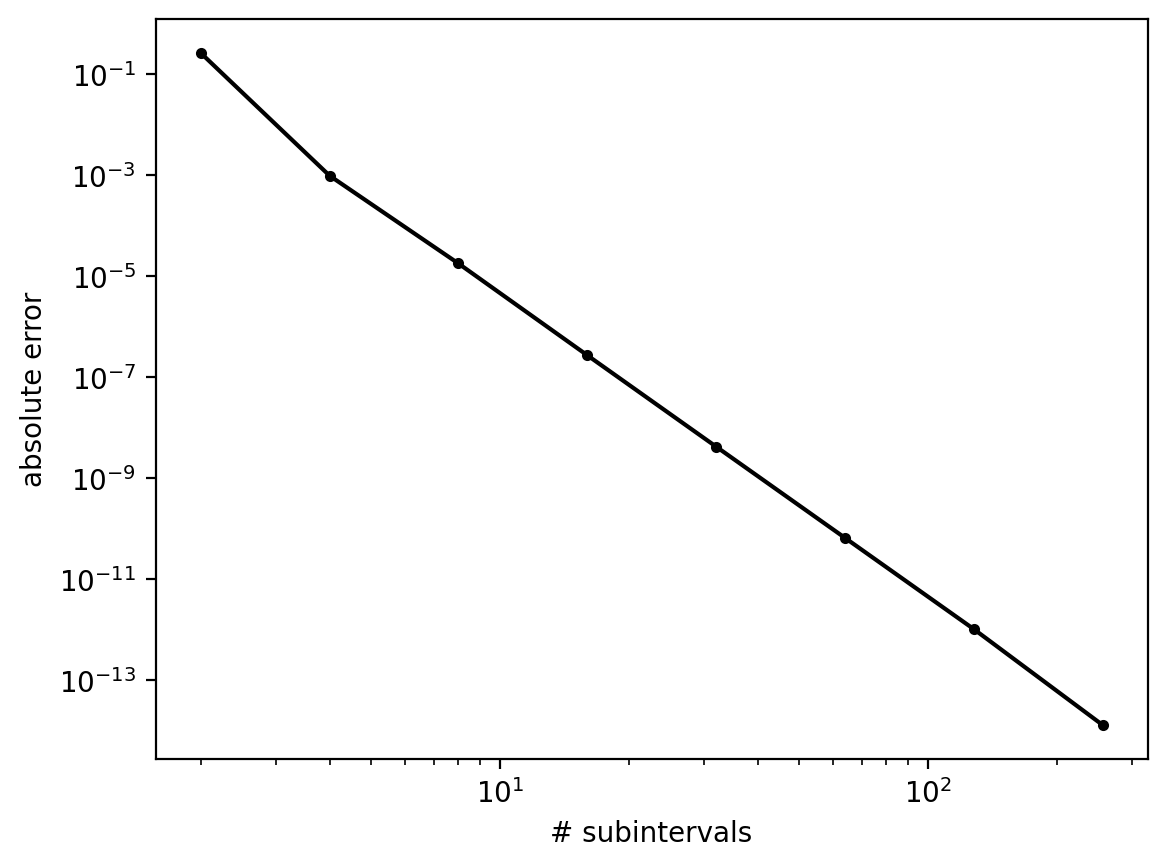

In [ ]:
integrand = lambda x: np.exp(x)*np.cos(5*x)
exact_int = np.cosh(np.pi/2)*5/13

N_subintervals = np.logspace(1, 8, 8, base=2, dtype=int)
approximations = []
for N_intervals in N_subintervals:
    x = np.linspace(-np.pi/2, np.pi/2, N_intervals + 1)
    h = x[1] - x[0]
    res = 0
    for x0 in x[:-1]:
        res += integration_rule(integrand, h, x0)
    approximations.append(res)
approximations = np.array(approximations)
abs_error = np.abs(approximations - exact_int)
plt.plot(N_subintervals, abs_error, ".-", color="black")
plt.yscale("log")
plt.xscale("log")
plt.ylabel("absolute error")
plt.xlabel("# subintervals")

slope = - np.log(abs_error[-2]/abs_error[-1]) / np.log(N_subintervals[-2]/N_subintervals[-1])
print("slope ~", slope);

# Problem 11

$$
\int_0^{2} dx\,\tan^{-1}(x) = \left.\left(x \tan^{-1}(x) - \frac{1}{2}\log (x^2 + 1)\right)\right|_{x=0}^{x=2} = 2 \tan^{-1}(2) - \frac{1}{2}\log (5)
$$

In [ ]:
def integration_rule(f, h, x0, w_c):
    n = w_c.shape[0] // 2
    return np.sum(f(x0 + w_c[n:]*h) * w_c[:n])

In [ ]:
integrand = lambda x: np.arctan(x)
exact_int = 2*np.arctan(2) - np.log(5)/2

Simpson = np.array([1/3, 4/3, 1/3, 0, 1/2, 1])
Simpson_3_8 = np.array([3/8, 9/8, 9/8, 3/8, 0, 1/3, 2/3, 1])

N_intervals = 3
x = np.linspace(0, 2, N_intervals + 1)
h = x[1] - x[0]
Simpson_approximation = 0
for x0 in x[:-1]:
    Simpson_approximation += integration_rule(integrand, h, x0, Simpson)*h/2

N_intervals = 2
x = np.linspace(0, 2, N_intervals + 1)
h = x[1] - x[0]
Simpson_3_8_approximation = 0
for x0 in x[:-1]:
    Simpson_3_8_approximation += integration_rule(integrand, h, x0, Simpson_3_8)*h/3

print("'exact' value of integral", exact_int)
print("approximated by Simpson rule", Simpson_approximation)
print("approximated by Simpson 3/8 rule", Simpson_3_8_approximation)

'exact' value of integral 1.4095784793711306
approximated by Simpson rule 1.4097607264628955
approximated by Simpson 3/8 rule 1.4100275814999237


$7$ functions evaluation for Simpson's rule with $3$ subintervals
```
xoxox
    xoxox
        xoxox
aooooooooooob
```
Error reads
$$
\sum_{i=1}^{3} \frac{1}{2880\times 3^5} M^{(i)}_4 (b-a)^5,
$$
where $M^{(i)}_4$ is an absolute value of derivative at some point on the subinterval $i$. The upper bound on this expression is
$$
\frac{1}{2880\times 3^4} \widetilde{M}_4 (b-a)^5,
$$
where $\widetilde{M}_4$ is an upper bound on absolute value of derivative on the whole interval.

$7$ functions evaluation for Simpson's $3/8$ rule with $2$ subintervales
```
xoxoxox
      xoxoxox
aooooooooooob
```
Error reads
$$
\sum_{i=1}^{2} \frac{1}{6480\times 2^5} M^{(i)}_4 (b-a)^5.
$$
Similar upper bound is
$$
\frac{1}{6480\times 2^4} \widetilde{M}_4 (b-a)^5.
$$

In [ ]:
print(2880*3**4)
print(6480*2**4)

233280
103680


We see that upper bound on Simpson's rule is
$$
\frac{1}{233280}\widetilde{M}_4 (b-a)^5,
$$
and upper bound on Simpson's $3/8$ rule is
$$
\frac{1}{103680}\widetilde{M}_4 (b-a)^5.
$$
This mean in the worst case composit Simpson's rule is at least $2$ times more accurate than composit Simpson's $3/8$ rule. Importantly, both rules have the same number of function evaluations.